In [1]:
import argparse
import os
import sys
from datetime import datetime

import numpy as np
import torch
import yaml
from tqdm import tqdm

from vae_miniworld import VAE

def count_parameters(net):
    # return the number of parameters of the model
    return sum(p.numel() for p in net.parameters() if p.requires_grad)


In [2]:
# we want to use GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
print("device used:", device)

device used: cuda


In [33]:
batch_size=128
nb_epochs=100

parameters = {
    "img_channels_vae": 1,
    "latent_dim_vae": 20,
    "beta_vae": 1,
    "learning_rate_vae": 1e-4,
    "batch_size_vae":64,
    "nb_epochs_vae":10
}


In [27]:
# import random rollout data from the Task-Hallway environment
data = np.load("data/randomRollout.npy")
data = data / 255
print(data.shape)

(100000, 60, 80, 1)


In [28]:
train_loader = torch.utils.data.DataLoader(
        dataset=data, batch_size=parameters['batch_size_vae'], shuffle=True
    )

In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module): # pylint: disable=too-many-instance-attributes
    """ VAE encoder """
    def __init__(self, img_channels, latent_dim):
        super(Encoder, self).__init__()
        self.latent_dim = latent_dim
        #self.img_size = img_size
        self.img_channels = img_channels

        self.conv1 = nn.Conv2d(img_channels, 32, 4, stride=2)
        self.conv2 = nn.Conv2d(32, 64, 4, stride=2)
        self.conv3 = nn.Conv2d(64, 128, 4, stride=2)
        self.conv4 = nn.Conv2d(128, 256, 4, stride=2)
        
        self.fc_mu = nn.Linear(768, latent_dim)
        self.fc_logsigma = nn.Linear(768, latent_dim)


    def forward(self, x): # pylint: disable=arguments-differ
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = x.view(x.size(0), -1)
        mu = self.fc_mu(x)
        logsigma = self.fc_logsigma(x)

        return mu, logsigma

class Decoder(nn.Module):
    """ VAE decoder """
    def __init__(self, img_channels, latent_dim):
        super(Decoder, self).__init__()
        self.latent_dim = latent_dim
        self.img_channels = img_channels

        self.fc1 = nn.Linear(latent_dim, 256)
        self.deconv1 = nn.ConvTranspose2d(256, 128, (4,7), stride=2)
        self.deconv2 = nn.ConvTranspose2d(128, 64, (6,5), stride=2)
        self.deconv3 = nn.ConvTranspose2d(64, 32, 6, stride=2)
        self.deconv4 = nn.ConvTranspose2d(32, img_channels, 6, stride=2)

    def forward(self, x): # pylint: disable=arguments-differ
        x = F.relu(self.fc1(x))
        x = x.unsqueeze(-1).unsqueeze(-1)
        x = F.relu(self.deconv1(x))
        x = F.relu(self.deconv2(x))
        x = F.relu(self.deconv3(x))
        reconstruction = torch.sigmoid(self.deconv4(x))
        return reconstruction

class VAE(nn.Module):
    """ Variational Autoencoder """
    def __init__(self, img_channels, latent_dim,beta = 1):
        super(VAE, self).__init__()
        self.encoder = Encoder(img_channels, latent_dim)
        self.decoder = Decoder(img_channels, latent_dim)
        self.beta = beta

    def forward(self, x): # pylint: disable=arguments-differ
        mu, logsigma = self.encoder(x)
        sigma = logsigma.exp()
        eps = torch.randn_like(sigma)
        z = eps.mul(sigma).add_(mu)

        recon_x = self.decoder(z)
        return recon_x, mu, logsigma

    def loss_function(self, recon_x, x, mu, logsigma):
        BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')
        KLD = -0.5 * torch.sum(1 + logsigma - mu.pow(2) - logsigma.exp())
        return BCE + self.beta*KLD, KLD
    
    def encoder_pass(self,x):
        return self.encoder(x)
    
    def decoder_pass(self,z):
        return self.decoder(z)


In [43]:
model = VAE(
            img_channels=parameters["img_channels_vae"],
            latent_dim=parameters["latent_dim_vae"],
            beta=parameters["beta_vae"],
        ).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=parameters["learning_rate_vae"])
print("number of parameters :", count_parameters(model))


number of parameters : 1985153


In [47]:

for epoch in range(nb_epochs):
    pbar = tqdm(train_loader)
    pbar.set_description("epoch %s/ loss=? " % str(epoch + 1))

    for x in pbar:
        imgs = x
        imgs = imgs.to(device).float()
        imgs = imgs.unsqueeze(1).squeeze(-1)
        # Feeding a batch of images into the network to obtain the output image, mu, and logVar
        out, mu, logsigma = model(imgs)

        # print(out.shape,imgs.shape,mu.shape,logsigma.shape)
        loss, loss_KL = model.loss_function(out, imgs, mu, logsigma)

        # Backpropagation based on the loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pbar.set_description(
            "epoch "
            + str(epoch + 1)
            + "/"
            + str(nb_epochs)
            + " loss= "
            + str(loss.cpu().detach().numpy())
            + " loss KL = "
            + str(loss_KL.cpu().detach().numpy())
        )

epoch 2/100 loss= 277110.16 loss KL = 4863.5415:  93%|█████████▎| 729/782 [00:29<00:02, 24.59it/s]


KeyboardInterrupt: 

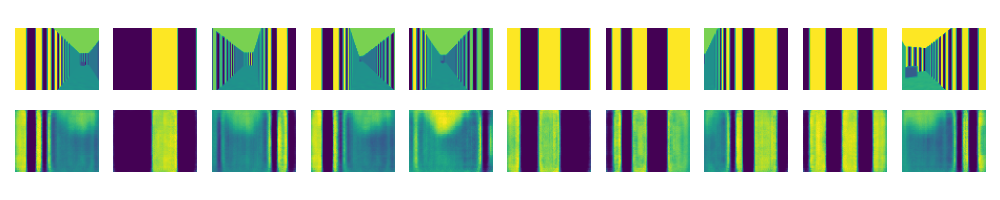

In [48]:
import random
import matplotlib.pyplot as plt

def plot_video_comparison(video, reconstructed_video):
    nb_frame = video.shape[0]
    fig, ax = plt.subplots(2, nb_frame, figsize=(nb_frame, 2))
    for i in range(video.shape[0]):
        ax[0, i].imshow(video[i, :, :])
        ax[0, i].axis("off")
    for i in range(video.shape[0]):
        ax[1, i].imshow(reconstructed_video[i, :, :])
        ax[1, i].axis("off")
    fig.tight_layout()

imgs = np.array(random.sample(list(data), 10))
imgs_tensor = torch.tensor(imgs).to(device).float().unsqueeze(1).squeeze(-1)
out_tensor, mu, logsigma = model(imgs_tensor)
out = out_tensor.cpu().detach().numpy()

plot_video_comparison(imgs.squeeze(-1),out.squeeze(1))

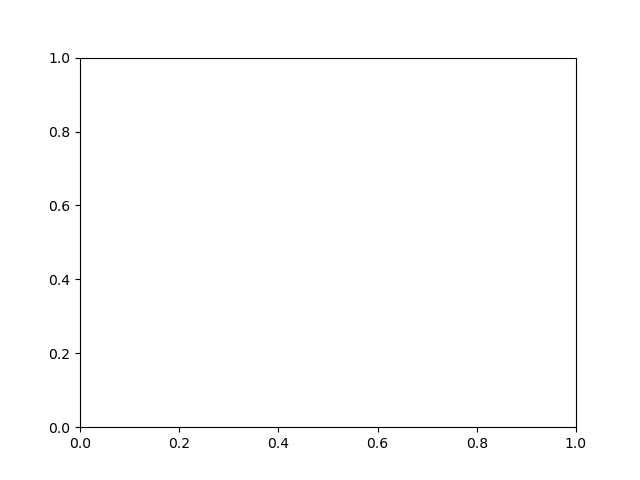

In [49]:
%matplotlib widget
import ipywidgets as widgets
from ipywidgets import FloatSlider, IntSlider, interactive_output, HBox, Layout

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

def plot_latent(**kwargs):
    """
    Print the current widget value in short sentence
    """
    z = []
    for z_i in locals()['kwargs']:
        z.append(locals()['kwargs'][z_i])
    z = torch.tensor(z).unsqueeze(0).float().to(device)
    out = model.decoder_pass(z)
    outimg = np.transpose(out[0].cpu().detach().numpy(), [1,2,0])
    ax.imshow(np.squeeze(outimg))
    ax.set_axis_off()
    fig.canvas.draw()
    
latent_dim = mu.shape[1]
latent_variables_init = {}
for i in range(latent_dim):
    latent_variables_init["z_"+str(i)] = mu[0,i].cpu().detach().item()
w = widgets.interactive(plot_latent,**latent_variables_init)
for slider in w.children:
    slider.min = -4
    slider.max = 4
    slider.orientation='vertical'
    slider.layout = Layout(width='90%')

display(HBox(w.children))